In [1]:
import warnings
warnings.filterwarnings('ignore')
from active_tester import ActiveTester
from active_tester.estimators.learned import Learned
from active_tester.query_strategy.random import Random
from active_tester.query_strategy.dpp import DPP
from sklearn.metrics import accuracy_score

from active_tester.label_estimation.methods import oracle_multiple_labels
import seaborn as sns
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import tensorflow as tf

## Overview

In this notebook, we discuss one of the more complex query strategies, which leverages determinantal point processes (DPP) to select items to vet.  The main idea behind DPPs is to emphasize diversity in the items selected.  Following the work of (__[Batch Active Learning Using Determinantal Point Processes](https://arxiv.org/abs/1906.07975)__), we create a DPP that emphasizes both diversity in the feature space as well as the importance of the item.  Importance can be defined in a variety of ways (as we saw in the other sampling strategies.  In this implementation, we simply use the classifier uncertainty.

To be specific, a $k$-DPP defines a probability distribution over subsets of items of size $k$ using a positive semi-definite matrix $L$.  Precisely, the probability of subset $S$ is proportional to the determinant of the submatrix defined by the indices in $S$:

$$
p(S) \propto det(L_S).
$$

In this package, we use

$$
L_{ij} = q_iq_j\exp\left( \frac{-||x_i-x_j||_2^2}{2} \right)
$$

where $q_i$ is the importance of item $i$ and $q_i$ is the entropy of the labels probabilities for item $i$.

The intuition behind this formulation is clear for subsets of size 2.  In this case,

$$
P({i,j}) \propto L_{ii}L_{jj} - L_{ij}^2 = q_i^2q_j^2 - q_i^2q_j^2\exp\left( \frac{-||x_i-x_j||_2^2}{2} \right)^2 = q_i^2q_j^2(1-\exp\left( \frac{-||x_i-x_j||_2^2}{2} \right)^2 )
$$

Thus, ${i,j}$ is more likely to be selected if $i$ and $j$ are important and far apart.

## Note

This query strategy should be considered experimental.  To get the most impact, the importance and distance measures must be chosen carefully for particular problems.

## Simple example

The example below demonstrates the general idea behind using DPP to select items.  We generate items in 5 separate clusters and then select 5 and 10 items using DPP and then 10 items using random sampling.  Note that the selected items appear as blue dots and the items that are not selected appear as red dots.

It's clear that DPP distributes the points better across the clusters (since it is aware of the distance between points).  Note that a greedy approximation algorithm is used to select the items and thus the subset selected is not necessarily the one with the highest probability.

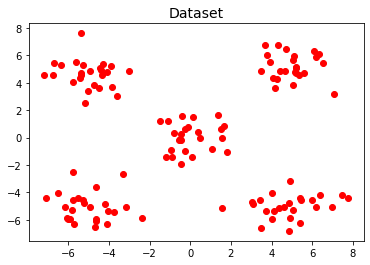

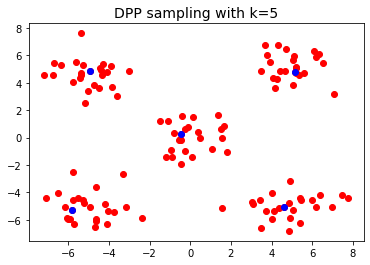

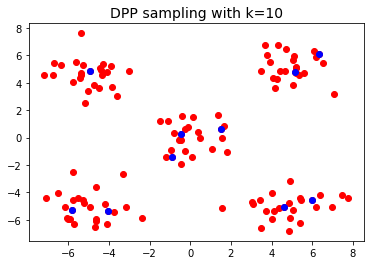

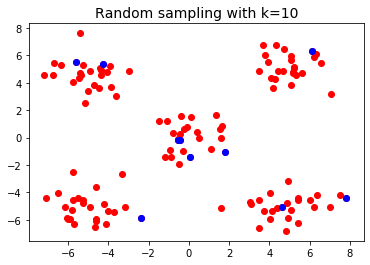

In [2]:
X1 = np.random.randn(25,2)
X2 = np.random.randn(25,2) + 5
X3 = np.random.randn(25,2) - 5
X4 = np.random.randn(25,2)
X4[:,1] = X4[:,1] + 5
X4[:,0] = X4[:,0] - 5
X5 = np.random.randn(25,2)
X5[:,1] = X5[:,1] - 5
X5[:,0] = X5[:,0] + 5

X = np.vstack((X1,X2,X3,X4,X5))

# The noisy labels are unused by DPP, so this is dummy input
y = np.zeros(125)
# We set the predicted probabilities to be the same for all items so that only distance is used to select point
y_hat = np.ones((125,2))*0.5

# Plot dataset
plt.scatter(X[:,0],X[:,1],c='r')
plt.title('Dataset', fontsize=14)
plt.show()

# Plot results from DPP with 5 samples
obj = DPP()
obj.set_args(X=X, y_noisy=y, p_classifier=y_hat)
out = obj.choose_indices(y_vetted=np.ones(125,dtype=int)*-1, k=5)
selected = X[out,:]
plt.scatter(X[:,0],X[:,1],c='r')
plt.scatter(selected[:,0],selected[:,1],c='b')
plt.title('DPP sampling with k=5', fontsize=14)
plt.show()

# Plot results from DPP with 10 samples
obj = DPP()
obj.set_args(X=X, y_noisy=y, p_classifier=y_hat)
out = obj.choose_indices(y_vetted=np.ones(125,dtype=int)*-1, k=10)
selected = X[out,:]
plt.scatter(X[:,0],X[:,1],c='r')
plt.scatter(selected[:,0],selected[:,1],c='b')
plt.title('DPP sampling with k=10', fontsize=14)
plt.show()

# Plot results from Random sampling with 10 samples
obj = Random()
obj.set_args(X=X, y_noisy=y, p_classifier=y_hat)
out = obj.choose_indices(y_vetted=np.ones(125,dtype=int)*-1, k=10)
selected = X[out,:]
plt.scatter(X[:,0],X[:,1],c='r')
plt.scatter(selected[:,0],selected[:,1],c='b')
plt.title('Random sampling with k=10', fontsize=14)
plt.show()

## Image dataset example

In the example, below, we apply the DPP sampling to an image classification problem.  This dataset and model are also used in the Image Example notebook and explained in more detail there.  

Note that if you do not already have the MNIST fashion dataset, this cell will download it.

In [3]:
def create_noisy_labels(ground_truth, prob, num_classes, rows):
    labels = np.random.randint(0,num_classes, (rows, 1))
    available_indices = np.arange(len(labels))
    indices = np.random.choice(available_indices, int(rows * prob), replace=False)
    
    for index in indices:
        labels[index] = ground_truth[index]
        
    return labels

fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

X = test_images

Y_ground_truth = test_labels

Y_noisy = np.hstack(((create_noisy_labels(Y_ground_truth, 0.75, len(class_names), len(X)),
                    create_noisy_labels(Y_ground_truth, 0.5, len(class_names), len(X)),
                    create_noisy_labels(Y_ground_truth, 0.25, len(class_names), len(X)))))

Y_noisy_confidence = np.ones((Y_noisy.shape[0], 1)) * 0.5

tf.keras.backend.clear_session()

inputs = tf.keras.Input(shape=(28,28,))
flatten = tf.keras.layers.Flatten()(inputs)
d = tf.keras.layers.Dense(64, activation='relu',name='embed')(flatten)
d2 = tf.keras.layers.Dense(10, activation='softmax',name='class_est')(d)

model2 = tf.keras.Model(inputs=inputs, outputs=[d2,d])

model2.compile(optimizer='adam',
              loss={'class_est':'sparse_categorical_crossentropy'},
              metrics=['accuracy'])
model2.fit(train_images, train_labels, epochs=10, validation_split = 0.1)
output = model2.evaluate(test_images, test_labels, verbose=0)
model_accuracy = output[2]

2019-12-06 10:38:22,014 WARNING Output embed missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to embed.


Train on 54000 samples, validate on 6000 samples
Epoch 1/10
54000/54000 [==============================] - 5s 100us/sample - loss: 2.4198 - class_est_loss: 2.4194 - class_est_accuracy: 0.5973 - val_loss: 0.9467 - val_class_est_loss: 0.9459 - val_class_est_accuracy: 0.6520
Epoch 2/10
54000/54000 [==============================] - 6s 103us/sample - loss: 0.8037 - class_est_loss: 0.8036 - class_est_accuracy: 0.7066 - val_loss: 0.7262 - val_class_est_loss: 0.7260 - val_class_est_accuracy: 0.7050
Epoch 3/10
54000/54000 [==============================] - 6s 117us/sample - loss: 0.6708 - class_est_loss: 0.6707 - class_est_accuracy: 0.7517 - val_loss: 0.7205 - val_class_est_loss: 0.7202 - val_class_est_accuracy: 0.7775
Epoch 4/10
54000/54000 [==============================] - 7s 121us/sample - loss: 0.6195 - class_est_loss: 0.6194 - class_est_accuracy: 0.7731 - val_loss: 0.5861 - val_class_est_loss: 0.5860 - val_class_est_accuracy: 0.7883
Epoch 5/10
54000/54000 [==============================]

Run the random and DPP query strategies for the classifier trained above.  We use the features in the learned estimator.  Due to the large number of features and the small number of vetted items, the optimization routine in the logistic regression classifier that underlies the learned estimator sometimes fails to converge.  A different representation of the features might be more appropriate here.

In [ ]:
# Initialize iterators and result holders
hist_raw_results = []

query_strategies_name = ['Random', 'DPP']
query_strategies = [Random(), DPP()]

num_budgets = 5
budget_counter = 100
trials = 5

# Loop through query strategies
for query_num,query_strategy in enumerate(query_strategies):
    
    counter = budget_counter
    cur_budget = 0
    
    # Loop through num samples
    while cur_budget < num_budgets:
        # Loop through trials
        for trial in range(trials):
            active_test = ActiveTester(Learned(metric=accuracy_score, 
                                               use_features=True,
                                               estimation_method=oracle_multiple_labels),
                                       query_strategy)

            active_test.standardize_data(is_img_byte=True, 
                                         X=X, 
                                         classes=class_names, 
                                         Y_ground_truth=Y_ground_truth,
                                         Y_vetted=None, 
                                         Y_noisy=Y_noisy)

            # Run model
            active_test.gen_model_predictions(model2,[('probabilities',10)])

            # Query vetted with current budget size and test
            active_test.query_vetted(interactive=False, 
                                     budget=counter, 
                                     batch_size=50, 
                                     raw=None, 
                                     visualizer=None)

            active_test.test()
            result = active_test.get_test_results()
            abs_error = np.abs(model_accuracy - result['tester_metric'])
            print("QueryStrat: %s\nBudget:" % (query_strategies_name[query_num]) +
                  " %d\nEvaluation Result: %s" % (counter, 
                                                  abs_error))

            # Add row to final results
            hist_raw_results.append([query_strategies_name[query_num], 
                                        abs_error, 
                                        counter])
            
        # Increment counters to next budget size
        counter += budget_counter
        cur_budget += 1
    
print(hist_raw_results)

Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "100" to "90"
QueryStrat: Random
Budget: 100
Evaluation Result: 0.09348421670288087
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "100" to "90"
QueryStrat: Random
Budget: 100
Evaluation Result: 0.046009006702880884
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "100" to "90"
QueryStrat: Random
Budget: 100
Evaluation Result: 0.05702728670288093
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "100" to "90"
QueryStrat: Random
Budget: 100
Evaluation Result: 0.07381249670288093
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "100" to "90"
QueryStrat: Random
Budget: 100
Evaluation Result: 0.07522622670288082
Beginning preprocessing to find vetted label

Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "400" to "390"
QueryStrat: DPP
Budget: 400
Evaluation Result: 0.023521846702880933
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "400" to "390"
QueryStrat: DPP
Budget: 400
Evaluation Result: 0.019576826702880856
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "500" to "490"
QueryStrat: DPP
Budget: 500
Evaluation Result: 0.026132846702880852
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "500" to "490"
QueryStrat: DPP
Budget: 500
Evaluation Result: 0.008223406702880909
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "500" to "490"
QueryStrat: DPP
Budget: 500
Evaluation Result: 0.014504566702880917
Beginning preprocessing to find vetted labels of e

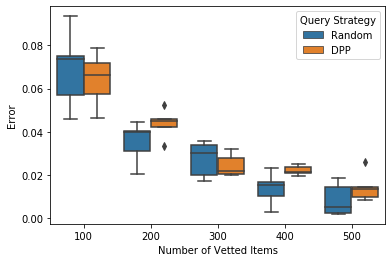

In [ ]:
pandas_results = pd.DataFrame(data = hist_raw_results, 
                              columns=['Query Strategy', 'Error', 'Number of Vetted Items'])

ax = sns.boxplot(y='Error', x='Number of Vetted Items', hue='Query Strategy', data=pandas_results)